In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
# # Organize data into train, valid, test dirs
# os.chdir('F:\Allen\Python\Keras\DeepLizard\CNN\data\dogs-vs-cats')
# if os.path.isdir('train/dog') is False:
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')

#     for i in random.sample(glob.glob('cat*'), 500):
#         shutil.move(i, 'train/cat')      
#     for i in random.sample(glob.glob('dog*'), 500):
#         shutil.move(i, 'train/dog')
#     for i in random.sample(glob.glob('cat*'), 100):
#         shutil.move(i, 'valid/cat')        
#     for i in random.sample(glob.glob('dog*'), 100):
#         shutil.move(i, 'valid/dog')
#     for i in random.sample(glob.glob('cat*'), 50):
#         shutil.move(i, 'test/cat')      
#     for i in random.sample(glob.glob('dog*'), 50):
#         shutil.move(i, 'test/dog')

# os.chdir('../../')

In [4]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

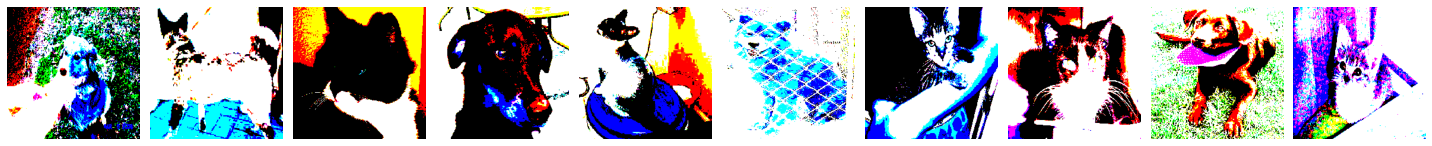

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

***Directory Iterator*** is an infinitely repeating dataset. (It will continue to generate *batches* to us as long as we want it to.

* When using a *Directory Iterator* we need to specify another parameter to the fit function: `steps_per_epoch`  

`steps_per_epoch` Total number of steps (batches of samples) to yield from our training set before declaring one epoch finished during the training process.  

> Typically equivalent to: No. of samples in our training set / Batch Size

`model.fit` would run infinitely if `steps_per_epoch` is not defined.  

*DeepLizard playlist videos will not contain the* `steps_per_epoch`, *must be included*

* If we are passing **validation data** to the `fit` function. We must also specify `validation_steps` (Acts in the same way as `steps_per_epoch` but for **validation data** instead of **training data**.  


* When we call `model.predict`, we need to specify the `steps` parameter. (Same as `steps_per_epoch`, but when using for predictions, it is the **Number of batches to yield from the test set before declaring the prediction round finished.**

## Build And Train A CNN

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape = (224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # the general choice of having more filters in later layers than in earlier ones is common
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', padding="same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

Now that the model is built, we need to **compile** the model.  

When we have only two classes, we could configure our output, we can use `binary_crossentropy` as **loss** instead of `categorical_crossentropy`. (Both work equally well and achieve the exact same result).  

With `binary_crossentropy`, the last layer should use `sigmoid`, rather than `softmax`, as its **activation function**.

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

Specify `steps_per_epoch` to indicate how many batches of samples from our training set should be passed to the model before declaring **one epoch complete**.  

Since we have 1000 samples in our **training set**, and our **batch size** is 10, then we set `steps_per_epoch` to be 100

In [13]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=10, verbose=2)

Epoch 1/10
100/100 - 43s - loss: 14.4762 - accuracy: 0.5720 - val_loss: 4.5923 - val_accuracy: 0.5950
Epoch 2/10
100/100 - 40s - loss: 2.1217 - accuracy: 0.7750 - val_loss: 3.3821 - val_accuracy: 0.6650
Epoch 3/10
100/100 - 40s - loss: 0.6907 - accuracy: 0.8840 - val_loss: 3.0649 - val_accuracy: 0.7100
Epoch 4/10
100/100 - 41s - loss: 0.2662 - accuracy: 0.9440 - val_loss: 3.6981 - val_accuracy: 0.6600
Epoch 5/10
100/100 - 41s - loss: 0.0960 - accuracy: 0.9750 - val_loss: 2.6903 - val_accuracy: 0.7200
Epoch 6/10
100/100 - 46s - loss: 0.0138 - accuracy: 0.9940 - val_loss: 2.5940 - val_accuracy: 0.7200
Epoch 7/10
100/100 - 44s - loss: 0.0324 - accuracy: 0.9890 - val_loss: 3.1875 - val_accuracy: 0.7050
Epoch 8/10
100/100 - 51s - loss: 0.0261 - accuracy: 0.9900 - val_loss: 2.3415 - val_accuracy: 0.7150
Epoch 9/10
100/100 - 44s - loss: 0.0114 - accuracy: 0.9960 - val_loss: 2.4482 - val_accuracy: 0.7000
Epoch 10/10
100/100 - 45s - loss: 6.9828e-04 - accuracy: 1.0000 - val_loss: 2.7652 - val_a

> *Training Accuracy* has reached **100%**  
> *Validation Accuracy* is only at **71%**  
>
> Some **overfitting** going on. (Model is not generalizing well)  
> Will not perform well on **Test Set**, can expect accuracy similar to *Validation Accuracy*

## CNN Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

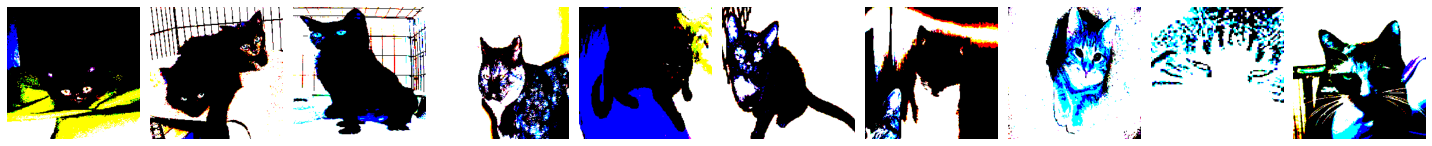

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

We specified for `test_batches`, `shuffle` = **False**

In [15]:
type(test_batches)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [16]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

`verbose=0` will show you nothing (silent)  

`verbose=1` will show you an animated progress bar like this:

$$[===================================]$$

`verbose=2` will just mention the number of epoch like this:

             Epoch 1/10

In [17]:
predictions = model.predict(x=test_batches, verbose=0) #We want no output.

In [18]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

We transform the one-hot encoded predicted labels to be in the same format as the true labels by only selecting the element with the highest value for each prediction using `np.argmax(predictions, axis=-1)`

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

##### Plot Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Inspect the `class_indices` for the *labels* so that we know in which order to pass them to our **confusion matrix**.

In [20]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[29 21]
 [13 37]]


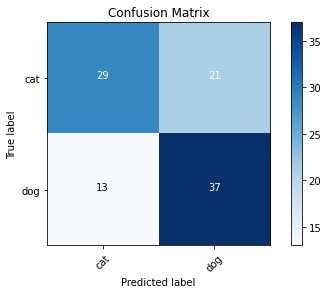

In [22]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix");

Model is definitely **overfitting**.